# Simple Example of a Simulation in jf1uids

## Imports

In [606]:
import jax.numpy as jnp

from jf1uids import SPHERICAL
from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids import get_helper_data
from jf1uids import primitive_state
from jf1uids import time_integration

import matplotlib.pyplot as plt

# set device to CPU
import jax
jax.config.update("jax_platform_name", "cpu")

## Simulation Setup

Setup a spherical shock test.

In [607]:
from jf1uids.geometry.boundaries import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY
from jf1uids.geometry.geometry import CARTESIAN
from jf1uids.option_classes.simulation_config import BACKWARDS

config = SimulationConfig(
    geometry = CARTESIAN,
    left_boundary = OPEN_BOUNDARY,
    right_boundary = OPEN_BOUNDARY,
    num_cells = 401,
    differentiation_mode = BACKWARDS
)

Next we setup the simulation parameters, things we might vary

In [608]:
params = SimulationParams(
    t_end = 0.2, # the typical value for a shock test
)

With this we generate some helper data, like the cell centers etc.

In [609]:
helper_data = get_helper_data(config)

## Example initial conditions

In [610]:
# # setup the shock initial fluid state in terms of rho, u, p
# shock_pos = 0.5
r = helper_data.geometric_centers
# rho_initial = jnp.where(r < shock_pos, 1.0, 0.125)
# u_initial = jnp.zeros_like(r)
# p_initial = jnp.where(r < shock_pos, 1.0, 0.1)

# gaussian
rho_initial = jnp.exp(-100 * (r - 0.5)**2)
u_initial = 0.0 * jnp.ones_like(r)
p_initial = 0.1 * jnp.exp(-100 * (r - 0.5)**2)

# get initial state
initial_state = construct_primitive_state(rho_initial, u_initial, p_initial)

## Running the simulation for the example initial conditions

In [611]:
final_state_reference = time_integration(initial_state, config, params, helper_data)
rho_final_reference, u_final_reference, p_final_reference = final_state_reference

### Visualization

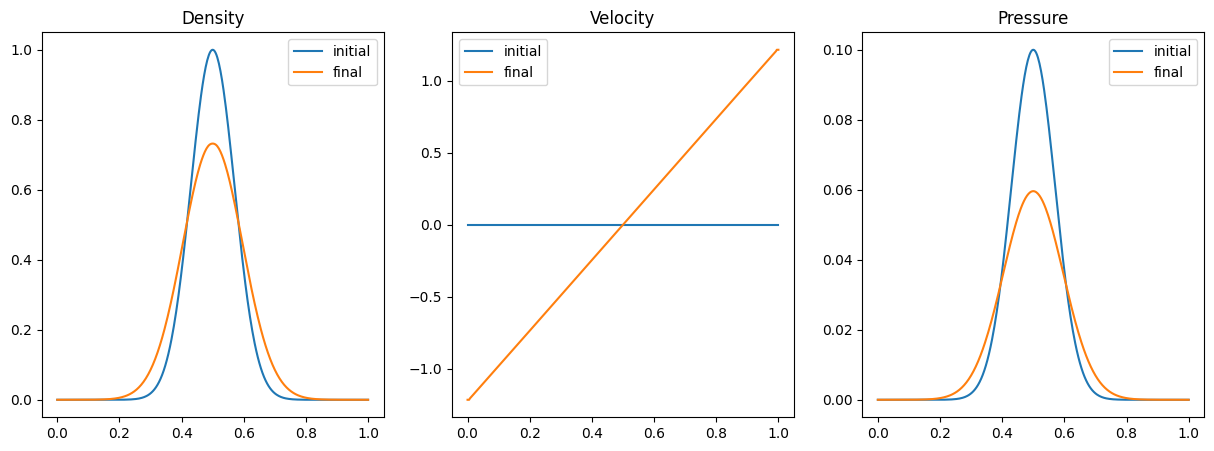

In [612]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(r, rho_initial, label='initial')
axs[0].plot(r, rho_final_reference, label='final')
axs[0].set_title('Density')
axs[0].legend()

axs[1].plot(r, u_initial, label='initial')
axs[1].plot(r, u_final_reference, label='final')
axs[1].set_title('Velocity')
axs[1].legend()

axs[2].plot(r, p_initial, label='initial')
axs[2].plot(r, p_final_reference, label='final')
axs[2].set_title('Pressure')
axs[2].legend()

## Retrieving the initial conditions from the final state by gradient descent

Let us start by defining the loss - we simply take the difference between the wanted final state and the final state of the proposed initial conditions.

In [613]:
def primitive_loss(reference, computed):
    return jnp.mean(jnp.abs(reference - computed))

loss = lambda initial_conditions: primitive_loss(
    final_state_reference,
    time_integration(initial_conditions, config, params, helper_data)
)

Our starting guess is a uniform state with zero velocity.

In [614]:
rho_initial_estimate = 0.0 * jnp.ones_like(r)
u_initial_estimate = jnp.zeros_like(r)
p_initial_estimate = 0.0 * jnp.ones_like(r)
# shock_pos_estimate = 0.5
# rho_initial_estimate = jnp.where(r < shock_pos_estimate, 0.8, 0.4)
# u_initial_estimate = jnp.zeros_like(r)
# p_initial_estimate = jnp.where(r < shock_pos_estimate, 0.8, 0.4)

initial_state_estimate = construct_primitive_state(rho_initial_estimate, u_initial_estimate, p_initial_estimate)

Let us try to find the correct initial state by gradient descent.

iter: 0, loss: 0.4372260272502899
iter: 100, loss: 0.43173009157180786
iter: 200, loss: 0.4263369143009186
iter: 300, loss: 0.4210461378097534
iter: 400, loss: 0.4158572256565094
iter: 500, loss: 0.41076913475990295
iter: 600, loss: 0.40578028559684753
iter: 700, loss: 0.40088826417922974
iter: 800, loss: 0.39608997106552124
iter: 900, loss: 0.39138296246528625
iter: 1000, loss: 0.3867650628089905
iter: 1100, loss: 0.38223376870155334
iter: 1200, loss: 0.3777877390384674
iter: 1300, loss: 0.3734261393547058
iter: 1400, loss: 0.36914828419685364
iter: 1500, loss: 0.36495447158813477


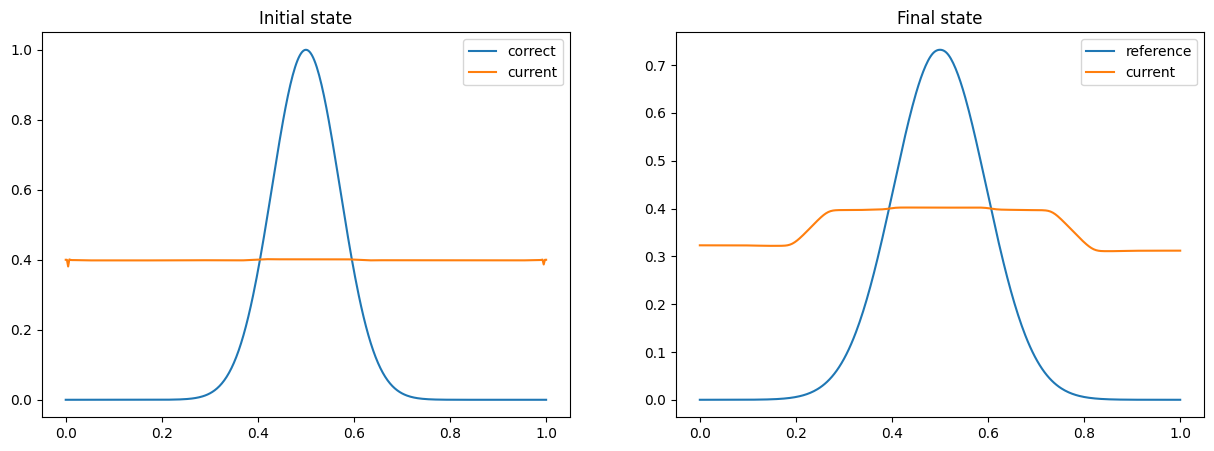

In [615]:
max_iter = 1600
tol = 1e-6
learning_rate = 1e-3

for i in range(max_iter):
    grad = jax.grad(loss)(initial_state_estimate)
    initial_state_estimate -= learning_rate * grad

    # set negative values to zero
    initial_state_estimate = jnp.where(initial_state_estimate < 0, 0, initial_state_estimate)

    if jnp.linalg.norm(grad) < tol:
        print(f'Converged after {i} iterations')
        break

    if i % 100 == 0:
        print(f'iter: {i}, loss: {loss(initial_state_estimate)}')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# left plot the correct and current initial state
axs[0].set_title('Initial state')
# right plot the reference and current final state
axs[1].set_title('Final state')

rho_estimate, u_estimate, p_estimate = initial_state_estimate
final_state = time_integration(initial_state_estimate, config, params, helper_data)
rho_final, u_final, p_final = final_state

axs[0].plot(r, rho_initial, label='correct')
axs[0].plot(r, rho_estimate, label='current')
axs[1].plot(r, rho_final_reference, label='reference')
axs[1].plot(r, rho_final, label='current')

axs[0].legend()
axs[1].legend()
plt.show()